### Project: Application of BERT to Electronic Health Records to predit the next diagnosis

#### General information
This notebook is used to create medical embedding based on preprocessed data. It also performs a downstream task Masked Language Model (MLM) to fine tune the model. The code requires the preprocessed data be available on the data folder. 

A separate notebook file is available to take the raw CSV files to BERT ready files in pkl format. The preprocessing notebook can be run on a local machine and it completes within reasonable time.

The training and validation processses takes very long time on a local computer using CPU. We used google colab pro to complete the process.

In [30]:
# Set this to False when running in google colab. 
# It copies all the required files from github and also installs required python libraries
local_mode = False

# Set to True to run the pre-training
train_model_flag = True

# Set to False if you want to exclude Age from pre-training (Ablation study)
include_age_seq = True

# Set to True to run Bayesian Optimization using Optane. This requires significant resources
# Don't enable unless you have signficant compute and memory resources
optane_hyper_param_tunning = False

In [2]:
if not local_mode:
  !mkdir commons
  !wget -P commons https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/utils.py
  !wget -P commons https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/__init__.py

  !mkdir models
  !wget -P models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/models/MLM.py
  !wget -P models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/models/NextXVisit.py
  !wget -P models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/models/optimizer.py
  !wget -P models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/models/BertConfig.py
  !wget -P models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/models/__init__.py

  !mkdir data
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/data/ages.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/data/concept.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/data/condition_codes.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/data/conditions.pkl

  !mkdir saved_models
  !wget -P saved_models https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/saved_models/mlm128.pt

  !mkdir images
  !wget -P images https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/images/cdm54.png
  !wget -P images https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/images/behrt_embeddings.png
  !wget -P images https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/images/behrt_model.png


--2023-05-07 19:44:33--  https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12014 (12K) [text/plain]
Saving to: ‘commons/utils.py’

utils.py            100%[===================>]  11.73K  --.-KB/s    in 0s      

2023-05-07 19:44:33 (66.9 MB/s) - ‘commons/utils.py’ saved [12014/12014]

--2023-05-07 19:44:33--  https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [3]:
import os
import pdb
import sys
import time
import pickle
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import commons.utils as utils

# set random seed for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
os.environ['PYTHONASHSEED'] = str(seed)

global_params = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Max number of condition codes including special tokens
    # Normal=256, 512=Out of memory
    'max_seq_len': 256,

    # Maximum patient age
    'max_age' : 110,

    # Month in age: 1=Age is in months(1 month), 12=Age is in year (12 months)
    'age_month' : 1,

    # Exlcude patients that have visits less than this value
    'min_visit': 5,

    # Batch size. (Normal=128, 256=Causes out of memory failure)
    'batch_size': 128,

     # Number of sample records used for training or validation. 0=All
    'training_sample': 0,

    # Number of training epochs (Main=10, Aggressive=100)
    'num_epochs': 5,

    # Number of steps for gradient accumulation
    'gradient_accumulation_steps': 1,
    
    # BERT number of self-attention heads (Main=12, Ablation=6)
    'attention_heads': 12,

    # BERT number of hidden layers (Main=6, Ablation=3)
    'num_hidden_layers': 6,

    # Number of hidden size = 4 * attention_heads * hidden_layers
    # (Normal=288, Ablation=72)
    'hidden_size': 288
}

# Optimization parameters
optim_param = {
    'lr': 3e-5, # Normal=3e-5, Ablation=1e-3
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

# File names
file_config = {
    'vocab': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'condition_codes.pkl',
    'data': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'conditions.pkl',
    'ages': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'ages.pkl',
    
    'model_path': 'C:/Birhanu/Education/UIL/cs598/Final/saved_models/' if local_mode else 'saved_models/',  # where to save/read model
    'model_name': 'mlm128',  # model name
    'log_file_name': 'log',  # log path
}


In [4]:
# Check the available device.
print(global_params["device"])

# This setting was added to avoid a runtime issue when running on gpu.
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

cuda


#### Load pre-processed data
Data has been pre-processed and saved as pkl file.

- conditions_seqs = [pid, [conditions]]
- condition_codes = [code, frequency_count]
- ages = [pid, [age for each condition]]

In [5]:
def adjust_age(ages):
  adj_ages = []

  for age in ages:
    age = int((int(age) - 4)/ 12)
    adj_ages.append(str(age + 4))

  return adj_ages 

# Load pickle files
conditions_seqs = pickle.load(open(file_config["data"], 'rb'))
age_seqs = pickle.load(open(file_config["ages"], 'rb'))
condition_codes = pickle.load(open(file_config["vocab"], 'rb'))

print("Size of the input dataset\n")
print(f"Shape of condition sequences: \n{conditions_seqs.shape}\n")
print(f"Shape of age sequences:\n{age_seqs.shape}\n")
print(f"Shape of condition concept codes:\n{condition_codes.shape}\n")

print("Sample data \n")
print(f"Condition sequences: \n{conditions_seqs.head()}\n")
print(f"Condition codes:\n{condition_codes.head()}\n")

print(f"Age sequences:\n{age_seqs.head()}\n")

# Ages: Source data as a month interval or age. 
# If we are using a 12-month interval adjust
if (global_params['age_month'] == 12):
  age_seqs["ages"]= age_seqs["ages"].apply(adjust_age)
  print(f"Adjusted age sequences:\n{age_seqs.head()}\n")

# convert to numpy array
conditions_seqs = np.array(conditions_seqs["conditions"])
age_seqs = np.array(age_seqs["ages"])

# Keep only a small size for training
if (global_params["training_sample"] > 0):
    conditions_seqs = conditions_seqs[:global_params["training_sample"]]
    age_seqs = age_seqs[:global_params["training_sample"]]

    print(f"*** NOTE ***: Input has been downsized to {global_params['training_sample']} records")


Size of the input dataset

Shape of condition sequences: 
(54498, 2)

Shape of age sequences:
(54498, 2)

Shape of condition concept codes:
(296, 3)

Sample data 

Condition sequences: 
      pid                                         conditions
0  176101  [1572199, SEP, 35207924, SEP, 35209141, SEP, 1...
1  176102  [35207924, 35211387, SEP, 1569634, SEP, 157606...
2  176103  [1570669, SEP, 1570669, SEP, 35208969, SEP, 35...
3  176104  [35208969, SEP, 35208968, 35208969, SEP, 35208...
4  176105  [1568078, 1569178, 1572190, 1572239, SEP, 1568...

Condition codes:
  condition                                     condition_name  counts
0     10851  Sprain of joints and ligaments of other parts ...    4323
1     11803                Sprain of ligaments of lumbar spine    4293
2   1567286                                       Other sepsis    3217
3   1567391                Viral infection of unspecified site    4177
4   1567392                                    Dermatophytosis    4198

Age

In [6]:
# Get the max number of visits per patient for all patients
max_code_seqs = np.max([len(seq) for seq in conditions_seqs])
max_age_seqs = np.max([len(seq) for seq in age_seqs])

# Inspect sequence data
print(f"Max number of code sequences: {max_code_seqs}")
print(f"Max number of age sequences: {max_age_seqs}")



Max number of code sequences: 447
Max number of age sequences: 447


#### Build ageVocab
This allows conversion between a person's age to an index or an index to age.

In [7]:
age2idx, idx2age = utils.age_vocab(max_age=110, mon=global_params["age_month"])

ageVocab = {
    'token2idx': age2idx,
    'idx2token': idx2age
}

assert ageVocab['token2idx']["30"] == 32
assert ageVocab['idx2token'][30] == "28"

#### Build condition code from/to index vocab for condition codes
The vocab will be used to convert from/to condition codes and indexes.
All the diagnosis codes are loaded from the diag_codes.pkl file.

In [8]:
conditionsVocab = utils.get_codes_vocab(file_config['vocab'])

# Note Index 0-4 are special tokens: 0=CLS, 1=SEP, 2=PAD, 3=MASK, 4=UNK
print(conditionsVocab['idx2token'][5])

assert conditionsVocab['idx2token'][5] == "10851"
assert conditionsVocab['token2idx']["10851"] == 5


10851


### View distribution of condition codes.
We removed conditions with less than 3000 ocurrences (se pre-processing notebook), but we wan to see the frequency distribution of the existing condition codes.

In [9]:
if not local_mode:
    %pip install --quiet mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


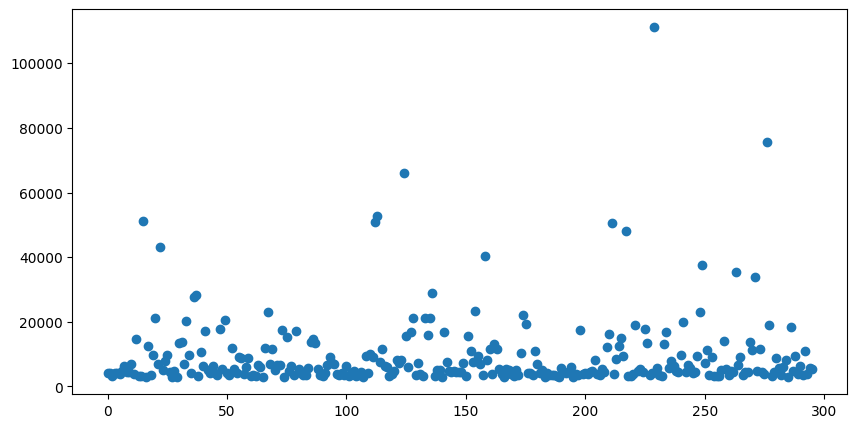

In [10]:
from matplotlib import pyplot as plt
import mplcursors

fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(condition_codes.index, condition_codes["counts"])

mplcursor = mplcursors.cursor(scatter, hover=True)
mplcursor.connect("add", lambda sel: sel.annotation.set_text(
    condition_codes[sel.target.index]["condition"]))


plt.show()


### Create a collate function to flatten the diagnosis codes

The seqs data has the following format: 
[pid, vid, [diagnosis codes]]

NOTE: This function is not currently used.

In [11]:
class Collator:

    def __call__(self, data):
        """
            Arguments:
                data: a list of samples fetched from 'MLMDataset'

            Outputs:
                code_seqs: a tensor of shape (# patients, len(condition_codes))
                age_seqs: A tensor of shape(# patients, max_age)
        """
        pass

collate_fn = Collator()


### Define custom dataset

In [12]:
from torch.utils.data.dataset import Dataset
import numpy as np
import torch


class MLMDataset(Dataset):
    """
        Dataloader for MLM task. 
        The input is a list of tokens specified by datafrmae and the output is a list of tokens with masking.
        The output is used to train the model to predict the masked tokens.

        The dataloaer will return the following:
            code: list = list of tokens
            age: list = list of age of the patient
           
            position: list = list of position indexes
            segmentation: list = list of segment indexes
            mask: list = list of mask indexes  (1 indicate the token is masked)
            label: list = list of label indexes (the label is the index of the token in the original tokens)

        the input dataframe must have the following columns:
            code: list = list of tokens
            age: list = list of age of the patient

    """

    def __init__(self, code_seqs, age_seqs, token2idx, age2idx, max_len, code='code', age='age'):
        self.max_len = max_len

        self.code_seqs = code_seqs
        self.age_seqs = age_seqs

        self.token2idx = token2idx
        self.age2idx = age2idx

    def __getitem__(self, index):
        """
        return: age, code, position, segmentation, mask, label
        """

        # extract data
        code_tokens = self.code_seqs[index][(-self.max_len+1):]
        age_tokens = self.age_seqs[index][(-self.max_len+1):]

        # avoid data cut with first element to be 'SEP'
        if code_tokens[0] != 'CLS':
            code_tokens = np.append(np.array(['CLS']), code_tokens)
            age_tokens = np.append(age_tokens[0], age_tokens)

        # mask 0:len(code) to 1, padding to be 0
        mask = np.ones(self.max_len)
        mask[len(code_tokens):] = 0
        num_tokens = len(code_tokens)

        # Get index for Unknown symbol and Pad symbol
        pad_symbol = self.token2idx.get('PAD')

        # Pad age sequences
        age_tokens = utils.seq_padding(age_tokens, self.max_len, token2idx=self.age2idx)

        # Masking: get masked code and label. Token -> Index
        out_tokens, label = utils.random_mask(code_tokens, token2idx=self.token2idx)
        code_tokens = utils.seq_padding(code_tokens, self.max_len)

        # get the number of masked tokens
        #n_mask = (torch.tensor(label) != -1).sum().item()
        #print(f"Index: {index}, Total: {num_tokens}, Masked tokens: {n_mask}, Percentage: {n_mask/num_tokens*100:.2f}%")

        # Additinal embeddings Position and Segment)
        position = utils.position_idx(code_tokens)
        segment = utils.index_seg(code_tokens)

        # Pad tokens and lables
        out_tokens = utils.seq_padding(out_tokens, self.max_len, symbol=pad_symbol)
        label = utils.seq_padding(label, self.max_len, symbol=-1)     

        return  torch.LongTensor(out_tokens), \
                torch.LongTensor(age_tokens), \
                torch.LongTensor(position), \
                torch.LongTensor(segment), \
                torch.LongTensor(mask), \
                torch.LongTensor(label)

    def __len__(self):
        return len(self.code_seqs)


In [13]:

token2idx = conditionsVocab["token2idx"]
age2idx = ageVocab["token2idx"]

dataset = MLMDataset(conditions_seqs, age_seqs, token2idx,age2idx, max_len=global_params['max_seq_len'])

if (global_params["training_sample"] > 0):
    assert len(
        dataset) == global_params["training_sample"], "The number of records is not correct"
else:
    assert len(dataset) == 54498, "The number of records is not correct"


In [14]:
# View batch data to test how the data is loaded.
from torch.utils.data import DataLoader

def inspect_batch():
    dataset = MLMDataset(conditions_seqs, age_seqs, token2idx, age2idx, max_len=global_params['max_seq_len'])
    train_loader = DataLoader(dataset=dataset, batch_size=global_params['batch_size'], shuffle=False)
    loader_iter = iter(train_loader)
    batch = next(loader_iter)

    batch = tuple(t.to(global_params['device']) for t in batch)
    input_ids, age_ids, posi_ids, segment_ids, attMask, masked_label = batch
    
    # Token codes
    p = 10
    print(f"Input:\n {input_ids[p, 0:20]}\n")
    print(f"Age:\n{age_ids[p, 0:20]}\n")
    print(f"Positions:\n{posi_ids[p, 0:20]}\n")
    print(f"Segments:\n{segment_ids[p, 0:20]}\n")

    print(attMask[p, 0:10])
    print(masked_label[p, 0:10])

    # Coditions vocab
    for i in range(5):
      print(f"{i} == {conditionsVocab['idx2token'][i]}")

    # Display input ids for the 2nd record in the batch
    print(input_ids[1, 0:10])

inspect_batch()
     

Input:
 tensor([  0, 254,   1, 133,   1,   3,   1, 133,   1, 133,   1, 133,   1, 133,
          1, 133, 292,   1, 116, 133], device='cuda:0')

Age:
tensor([397, 397, 397, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412,
        412, 412, 412, 412, 412, 412], device='cuda:0')

Positions:
tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8],
       device='cuda:0')

Segments:
tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([ -1,  -1,  -1,  -1,  -1, 133,  -1,  -1,  -1,  -1], device='cuda:0')
0 == CLS
1 == SEP
2 == PAD
3 == MASK
4 == UNK
tensor([  0,   3, 275,   3,  96,   1, 203,   3,  78, 163], device='cuda:0')


In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=dataset, batch_size=global_params['batch_size'], shuffle=True)

loader_iter = iter(train_loader)
code_tokens, age_tokens, position, segment, mask, label = next(loader_iter)

assert code_tokens.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert age_tokens.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert position.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert segment.shape == (global_params['batch_size'], global_params['max_seq_len'])


### Pre-taining BEHRT

##### Define BERT model configuration

In [16]:
model_config = {
    # number of disease + symbols for word embedding
    'vocab_size': len(conditionsVocab['token2idx'].keys()),

    # word embedding and seg embedding hidden size  
    'hidden_size': global_params['hidden_size'],

    # number of vocab for seg embedding
    'seg_vocab_size': 2,  

    # number of vocab for age embedding
    'age_vocab_size': len(ageVocab['token2idx'].keys()),
    
    # maximum number of tokens
    'max_position_embedding': global_params['max_seq_len'],

    # dropout rate
    'hidden_dropout_prob': 0.1, 

    # number of multi-head attention layers required
    'num_hidden_layers': global_params['num_hidden_layers'] ,  

    # number of attention heads
    'num_attention_heads': global_params['attention_heads'], 

    # multi-head attention dropout rate
    'attention_probs_dropout_prob': 0.1,  

    # the size of the "intermediate" layer in the transformer encoder
    'intermediate_size': 512,

    # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'hidden_act': 'gelu',

    # The layer normalization epsilon
    'initializer_range': 0.02, 
}

In [17]:
if not local_mode:
    %pip install --quiet pytorch_pretrained_bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.0 MB/s eta 0:00:00


In [18]:
import models
import pytorch_pretrained_bert as Bert
import sklearn.metrics as skm

import models.BertConfig as BertConfig
import models.MLM as MLM
from models.optimizer import adam

conf = BertConfig.BertConfig(model_config)
model = MLM.BertForMaskedLM(conf)
model

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4488397


In [19]:
model = model.to(global_params['device'])
optim = adam(params=list(model.named_parameters()), config=optim_param)


In [20]:
def cal_acc(label, pred):
    logs = nn.LogSoftmax(dim=-1)
    
    label = label.cpu().numpy()

    # Exclude tokens that were not masked
    ind = np.where(label != -1)[0]

    # Get True label
    truelabel = label[ind]

    # Get the true prediction
    truepred = pred.detach().cpu().numpy()
    truepred = truepred[ind]
    truepred = logs(torch.tensor(truepred))
    outs = [np.argmax(pred_x) for pred_x in truepred.numpy()]

    # Calculate precision
    precision = skm.precision_score(truelabel, outs, average='micro')

    return precision


In [21]:
def train(epoch, loader):
    tr_loss = 0
    temp_loss = 0
    steps = 0
    nb_tr_examples = 0
    temp_acc = 0
    tr_acc = 0
    UPDATE_INTERVAL = 100
    batch_step_count = 0

    start = time.time()

    for step, batch in enumerate(loader):
        batch = tuple(t.to(global_params['device']) for t in batch)
        token_ids, age_ids, posi_ids, segment_ids, attMask, masked_label = batch
        batch_step_count += 1

        # Ablation: AGE
        if not include_age_seq:
          age_ids = None

        # Call Bert Model
        loss, pred, label= model(token_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, masked_lm_labels=masked_label)

        if global_params['gradient_accumulation_steps'] > 1:
            loss = loss/global_params['gradient_accumulation_steps']
            
        loss.backward()

        temp_loss += loss.item()
        tr_loss += loss.item()

        # Calculate MLM accuracy
        acc = cal_acc(label, pred)
        
        temp_acc += acc
        tr_acc += acc

        nb_tr_examples += token_ids.size(0)
        steps += 1

        if steps % UPDATE_INTERVAL == 0 or nb_tr_examples >= conditions_seqs.shape[0]:
            print("epoch: {}\t| Batches: {}\t| Total samples: {}\t |Loss: {}\t| precision: {:.4f}\t| time: {:.2f}".format(
                epoch, steps, nb_tr_examples, temp_loss/batch_step_count, temp_acc/batch_step_count, time.time()-start))
            
            batch_step_count = 0
            temp_loss = 0
            temp_acc = 0
            start = time.time()

        if (steps + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()

    print("** ** * Saving fine - tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    
    utils.create_folder(file_config['model_path'])
    output_model_file = os.path.join(file_config['model_path'], file_config['model_name'] +'.pt')
    torch.save(model_to_save.state_dict(), output_model_file)
        
    cost = time.time() - start
    acc = np.mean(tr_acc)
    return tr_loss, cost, tr_acc

#### Train MLM model
Train model, get token embeddings and save to disk.

In [31]:
def exec_training():
  f = open(os.path.join(file_config['model_path'],file_config['log_file_name']), "w")
  print("Training model. This will take time...")

  model.train(True)
  best_acc = 0

  for e in range(global_params["num_epochs"]):
      loss, time_cost, acc = train(e, train_loader)
      data_len = len(train_loader)
      loss = loss/data_len
      acc = acc/ data_len
      if (best_acc < acc):
        best_acc = acc

      f.write('Epoch={}\t, Loss={}\t, Acc={}\t, Time cost={}\n'.format(e, loss, acc, time_cost))

  f.close()
  print(f"Best accuracy: {best_acc}")

if (train_model_flag):
  exec_training()



Training model. This will take time...


/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


epoch: 0	| Batches: 100	| Total samples: 12800	 |Loss: 4.151539986133575	| precision: 0.3318	| time: 85.70
epoch: 0	| Batches: 200	| Total samples: 25600	 |Loss: 3.972458381652832	| precision: 0.3415	| time: 82.59
epoch: 0	| Batches: 300	| Total samples: 38400	 |Loss: 3.832119574546814	| precision: 0.3589	| time: 82.60
epoch: 0	| Batches: 400	| Total samples: 51200	 |Loss: 3.6383685994148256	| precision: 0.3661	| time: 82.59
epoch: 0	| Batches: 426	| Total samples: 54498	 |Loss: 3.542133065370413	| precision: 0.3665	| time: 21.41
** ** * Saving fine - tuned model ** ** * 
epoch: 1	| Batches: 100	| Total samples: 12800	 |Loss: 3.455389142036438	| precision: 0.3726	| time: 82.49


KeyboardInterrupt: ignored

#### Reload the model from disk

In [23]:
output_model_file = os.path.join(file_config['model_path'], file_config['model_name']) + '.pt'
model.eval()

data = torch.load(output_model_file, map_location='cpu')
print(data.keys())
word_embedding = data['bert.embeddings.word_embeddings.weight']
print(word_embedding.shape)


odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.segment_embeddings.weight', 'bert.embeddings.age_embeddings.weight', 'bert.embeddings.posi_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.wei

In [24]:
output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])+'.pt'
torch.save(model.state_dict(), output_model_file)

#### Map the word embedding to the original vocab in 2D space

In [25]:
if not local_mode:
  %pip install --quiet mpld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 6.4 MB/s eta 0:00:00


In [26]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
from numpy.linalg import norm

# Find the top X similar conditions
data = word_embedding

max_similars = 20
similars = []
for i in range(5, len(data)-1):
  for j in range(i+1, len(data)):
    sort_list = False

    similarity =  cos(data[i], data[j])
    item = (i, j, similarity)
  
    if (len(similars) <  max_similars):
      similars.append(item)
      sort_list = True
    else:
      if (similarity > similars[max_similars-1][2] ):
        similars[max_similars-1] = item
        sort_list = True

    if (sort_list):
      similars.sort(key=lambda item:item[2], reverse=True)

for item in similars:
  code1 = conditionsVocab["idx2token"][item[0]]
  label1 = condition_codes[condition_codes["condition"] == str(code1)]["condition_name"].values[0]

  code2 = conditionsVocab["idx2token"][item[1]]
  label2 = condition_codes[condition_codes["condition"] == str(code2)]["condition_name"].values[0]

  #print(f"A={item[0]}, B={item[1]}, Label={label1} \n\t {label2}, Similarity={item[2]}")
  print(f"{label1} \n\t {label2}, Similarity={item[2]}")


Other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium 
	 Weeks of gestation, Similarity=0.6521257162094116
Supervision of high risk pregnancy 
	 Other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium, Similarity=0.6405696272850037
Supervision of high risk pregnancy 
	 Weeks of gestation, Similarity=0.637302041053772
Other hemorrhoids 
	 Polyp of colon, Similarity=0.6263095736503601
Neoplasm of uncertain behavior of skin 
	 Actinic keratosis, Similarity=0.6259315013885498
Subacute and chronic vulvitis 
	 Other specified noninflammatory disorders of vagina, Similarity=0.624294638633728
Obstructive and reflux uropathy 
	 Calculus of kidney and ureter, Similarity=0.6137647032737732
Benign neoplasm of colon, rectum, anus and anal canal 
	 Diverticular disease of intestine, Similarity=0.6117430329322815
Other diseases of anus and rectum 
	 Hemorrhoids and perianal venous thrombosis, Similarit

In [27]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import mpld3

data = word_embedding

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(data)

# Obtain labels for each point to use as a color
x = z[:, 0]
y = z[:, 1]

# plot
fig = plt.figure( figsize=(10,4), facecolor="white", edgecolor='white')
ax = fig.add_subplot()

# Create the tooltip
labels=[""] * 5

colors = np.zeros((len(conditionsVocab["idx2token"])))

for i in range(5, len(x)):
    code = conditionsVocab["idx2token"][i]
    label = condition_codes[condition_codes["condition"] == str(code)]["condition_name"].values[0]
    labels.append('<div class="tooltip">' + label + '</div>')

    # Highlight selected conditions for visual inspection
    if "diabetes" in label.lower():
      colors[i] = 1
    
    if "otitis" in label.lower():
       colors[i] = 1
    
    if "anemia" in label.lower():
       colors[i] = 1

    if "bipolar" in label.lower():
       colors[i] = 1
    
    if "bronchitis" in label.lower():
       colors[i] = 1
       

scatter = ax.scatter(x, y, c=colors, cmap='rainbow')
ax.set_facecolor("white")
plt.rcParams['axes.facecolor'] = 'gray'

# CSS
css = """
  .tooltip
  {
    background-color: #cccccc;
    font-family:Arial, Helvetica, sans-serif;
    border: 1px solid black;
    text-align: right;
  }
"""
tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels, css=css)

# Add the tooltip to the plot
mpld3.plugins.connect(fig, tooltip )

# Display the plot
mpld3.display()



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.002s...
[t-SNE] Computed neighbors for 301 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.228540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.205742
[t-SNE] KL divergence after 1000 iterations: 0.883180


#### Model hyper-parameters optimization

In [28]:
! pip install --quiet optuna
! pip install --quiet optuna-dashboard
# optuna-dashboard sqlite:///db.sqlite3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 8.2 MB/s eta 0:00:00


In [29]:
import optuna

def define_model(trial: optuna.trial.Trial, config):
  conf = BertConfig.BertConfig(config)
  model = MLM.BertForMaskedLM(conf)
  return model

def define_optimizer(trial: optuna.trial.Trial, model):
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  return optimizer

def get_config_with_trial_params(trial: optuna.trial.Trial ):
    # Define model config parameters
    num_hidden_layers =  trial.suggest_int('num_hidden_layers', 2, 6)  
    #num_attention_heads = trial.suggest_int('num_attention_heads', 3, 12)
    #hidden_size = num_hidden_layers * num_attention_heads * model_config["intermediate_size"]

    # Create model config
    config = model_config.copy()
    config["num_hidden_layers"] = num_hidden_layers
    #config["num_attention_heads"] = num_attention_heads
    #config["hidden_size"] = hidden_size

    return config

def objective(trial):
    
    # Define model config parameters
    config = get_config_with_trial_params(trial)

    # Define optimizer parameters
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer_params= {
        'lr': lr,
        'warmup_proportion': 0.1,
        'weight_decay': 0.01
    }
        
    # Define model
    model = define_model(trial, config)
    optimizer = adam(params=list(model.named_parameters()), config=optimizer_params)
     
    # Train model
    model.train()
    tr_loss=0

    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()
      
      token_ids, age_ids, posi_ids, segment_ids, attMask, masked_label = batch

      # Call MLM Model
      loss, pred, label = model(token_ids, age_ids, segment_ids, posi_ids,
                                attention_mask=attMask, 
                                masked_lm_labels=masked_label)
    
      loss.backward()
      optimizer.step()
      tr_loss += loss.item()

    data_len = len(train_loader)
    loss = tr_loss/data_len
    return cal_acc(label, pred)

    #if trial.should_prune():
    #    raise optuna.exceptions.TrialPruned()

if optane_hyper_param_tunning:
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=10)

  trial = study.best_trial

  print('Accuracy: {}'.format(trial.value))
  print("Best hyperparameters: {}".format(trial.params))
